In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import re, string, unicodedata
import nltk
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS #get_ipython().system('pip install wordcloud')
from nltk.corpus import stopwords
import seaborn as sns
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # prevent showing future warning
pd.options.mode.chained_assignment = None 

from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score,KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [2]:
tweet_input = pd.read_csv("covid19_tweets.csv")

### Data Overview

In [3]:
tweet_input.info()
tweet_input.isnull().sum()
tweet_input.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179108 entries, 0 to 179107
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_name         179108 non-null  object
 1   user_location     142337 non-null  object
 2   user_description  168822 non-null  object
 3   user_created      179108 non-null  object
 4   user_followers    179108 non-null  int64 
 5   user_friends      179108 non-null  int64 
 6   user_favourites   179108 non-null  int64 
 7   user_verified     179108 non-null  bool  
 8   date              179108 non-null  object
 9   text              179108 non-null  object
 10  hashtags          127774 non-null  object
 11  source            179031 non-null  object
 12  is_retweet        179108 non-null  bool  
dtypes: bool(2), int64(3), object(8)
memory usage: 15.4+ MB


,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False


### Data cleaning and processing

In [4]:
## filter tweet by hashtags that contains top 50 words
tweet= tweet_input['text']
def convert(lst):
    return ([i for item in lst for i in item.split()])
panda_df = pd.DataFrame(data =tweet_input, columns = ["text","hashtags"])
panda_df=panda_df[panda_df['hashtags'].notnull()]
df = pd.DataFrame(convert(panda_df['hashtags']))
df=df.replace(',','', regex=True)
df=df.replace("]",'', regex=True)
df=df.replace('\'','', regex=True)
df=df.replace('\[''', '', regex=True)
df=df.replace('ー', '', regex=True)
df=df.replace('_', '', regex=True)
df=df.replace('__', '', regex=True)
df.columns=['Words']
df['Words']=df['Words'].str.lower()
s=df.value_counts()
Words=pd.DataFrame(s.nlargest(50))
modified = Words.reset_index()
modified.columns=['Words',"Counts"]

print(modified)
#print(modified) 
selection = modified['Words'].tolist()
filtered_tweet=tweet_input[tweet_input['hashtags'].notnull()]
## hashtag count top 50
mask = filtered_tweet.hashtags.apply(lambda x: any(item for item in selection if item in x))
filtered_tweet=filtered_tweet[mask]

                  Words  Counts
0               covid19  101782
1           coronavirus   10197
2              pandemic    1625
3                 covid    1299
4                 india    1193
5                corona    1162
6                 trump    1101
7              lockdown     963
8   coronaviruspandemic     882
9             wearamask     800
10    coronavirusupdate     721
11               odisha     707
12              vaccine     703
13                china     544
14    indiafightscorona     538
15   coronavirusupdates     521
16             staysafe     497
17                  usa     483
18             breaking     480
19     socialdistancing     459
20                masks     457
21               health     441
22            covidiots     426
23                 mask     420
24               russia     413
25         coronainfoch     405
26                   us     401
27                   uk     382
28                blood     351
29   hydroxychloroquine     337
30      

In [5]:
data = filtered_tweet[['user_name','date','text','hashtags','user_location']].reset_index(drop=True)

In [6]:
tweet=data['text'].copy()
##remove website
tweet= tweet.str.replace(r"http\S+", "")
#remove hashtags
tweet = tweet.str.replace(r'#','', regex=True)
#remove mentions
tweet = tweet.str.replace(r'@[A-Za-z0-9_]+','', regex=True)
##remove punctuation
tweet = tweet.str.replace('[^\w\s]','')
 ##remove numbers
tweet = tweet.str.replace(r'\d+', '')
##remove underscore
tweet = tweet.str.replace(r"\W+_\W+", '', regex=True)
tweet = tweet.str.replace(r"_", '', regex=True)
##remove brackets
tweet = tweet.str.replace('\[.*?\]', '')
##convert to lower case
tweet= tweet.str.lower()
##drop empty rows
tweet.dropna(inplace=True)
##remove leading and ending white space
tweet = tweet.str.strip()
tweet = tweet.str.replace(r"\n", '', regex=True)
tweet = tweet.str.replace('  ', ' ', regex=True)
data['text']=tweet
stopwords = stopwords.words('english')
def remove_specialwords(words):
    words = unicodedata.normalize('NFKD', words).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return words
data['text'] =data.apply(lambda row:remove_specialwords(row['text']), axis=1)

### Sentiment Analysis using NLTK(nlp) 

In [7]:
# ref NLTK sentiment analyse https://www.nltk.org/howto/sentiment.html
#get_ipython().system('pip install vaderSentiment')
sentiment_analyzer = SentimentIntensityAnalyzer()
scores=[]
sentiment_=[]
sentiment_fit_=[]
for i in data['text']:
    sentiment_score = sentiment_analyzer.polarity_scores(i)
    score = sentiment_score['compound']
    scores.append(score)
data=data.assign(sentiment_score = scores)

for i in data['sentiment_score']:
    if i>0:
        sentiment='positive'
        sentiment_fit=1
    elif i==0:
        sentiment='neutral'
        sentiment_fit=0
    else:
        sentiment='negative'
        sentiment_fit=-1
    sentiment_.append(sentiment)
    sentiment_fit_.append(sentiment_fit)
data=data.assign(sentiments=sentiment_)
data=data.assign(sentiment_fit=sentiment_fit_)
data.head()

,user_name,date,text,hashtags,user_location,sentiment_score,sentiments,sentiment_fit
0,DIPR-J&K,2020-07-25 12:27:08,july media bulletin on novel coronavirusupdate...,"['CoronaVirusUpdates', 'COVID19']",Jammu and Kashmir,0.3182,positive,1
1,🎹 Franz Schubert,2020-07-25 12:27:06,coronavirus covid deaths continue to rise its ...,"['coronavirus', 'covid19']",Новоро́ссия,-0.4445,negative,-1
2,Prathamesh Bendre,2020-07-25 12:26:59,praying for good health and recovery of covidc...,"['covid19', 'covidPositive']",NaN,0.6597,positive,1
3,Beautify Data,2020-07-25 12:26:17,an update on the total covid cases recoveries ...,"['covid19', 'Africa']","Miami, FL",-0.3400,negative,-1
4,CARLINO,2020-07-25 12:25:29,crazy that the world has come to this but as a...,['covid19'],"New Orleans, LA",-0.6249,negative,-1


### Machine learning Model Training and Testing

In [9]:
# ref https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
import nltk
#nltk.download() If there is error with nltk.word_tokenize, please use this line to download, need to download to run
#selected=data.iloc[0:5000]
description_list = []
vectorizer = CountVectorizer(stop_words='english',lowercase=False)
for text in data['text']:
    tokenize=nltk.word_tokenize(text)
    words=[]
    for i in tokenize:
        lemma = nltk.WordNetLemmatizer()
        word=lemma.lemmatize(i)
        words.append(word)
    words_=' '.join(words)
    description_list.append(words_)
X = vectorizer.fit_transform(description_list).toarray()
y = data['sentiment_fit']
X_train, X_valid, y_train, y_valid = train_test_split(X, y,test_size = 0.4, random_state = 42)

## Creat K-fold here 
kf=KFold(n_splits=5)

##If witout using cross validation, please use print("Navie Bayes algorithm accuracy=",nb.score(X_valid,y_valid)*100)
##Same for the other models below
nb=GaussianNB()
nb_model=nb.fit(X_train,y_train)
#Test
y_pred=nb.predict(X_valid)
nb_score=cross_val_score(nb_model,X_train,y_train,cv=kf)
print("Navie Bayes algorithm accuracy=",(nb_score.mean()*100))

knn=KNeighborsClassifier(n_neighbors=3)
knn_model=knn.fit(X_train,y_train)
y_pred=knn.predict(X_valid)
knn_score=cross_val_score(knn_model,X_train,y_train,cv=kf)
print("Knn algorithm accuracy=",(knn_score.mean()*100))

model = MultinomialNB()
MNB_model=model.fit(X_train,y_train)
y_pred=model.predict(X_valid)
MNB_score=cross_val_score(MNB_model,X_train,y_train,cv=kf)
print("multinomial Naive Bayes classifier accuracy=",(MNB_score.mean()*100))

rf_model = RandomForestClassifier(n_estimators=100,random_state=1)
rf_model=rf_model.fit(X_train, y_train)
y_pred=rf_model.predict(X_valid)
rf_score=cross_val_score(rf_model,X_train,y_train,cv=kf)
print("RandomForest accuracy=",(rf_score.mean()*100))

lr=LogisticRegression()
lr_model=lr.fit(X_train, y_train)
y_pred=lr_model.predict(X_valid)
lr_score=cross_val_score(lr_model,X_train,y_train,cv=kf)
print("Logistic Regression algorithm accuracy =",(lr_score.mean()*100))


NN_model= MLPClassifier(solver='lbfgs', hidden_layer_sizes=())
NN_model=NN_model.fit(X_train, y_train)
NN_score=cross_val_score(NN_model,X_train,y_train,cv=kf)
print("Multi-layer Perceptron accuracy =",(NN_score.mean()*100))

 #models = pd.DataFrame({
 #    'Model': ['Navie Bayes', 'K-Nearest Neighbors', 
 #              'Multinomial Naive Bayes', 'Random Forest', 
 #              'Logistic Regression', 'Multi-layer Perceptron'],
 #    'Test accuracy': [nb.score(X_valid,y_valid)*100, 
 #                      knn.score(X_valid,y_valid)*100,
 #                     model.score(X_valid,y_valid)*100, 
 #                     rf_model.score(X_valid,y_valid)*100,
 #                     lr.score(X_train, y_train)*100, 
 #                     NN_model.score(X_train, y_train)*100]})

models = pd.DataFrame({
        'Model': ['Navie Bayes', 'K-Nearest Neighbors', 
                  'Multinomial Naive Bayes', 'Random Forest', 
                  'Logistic Regression', 'Multi-layer Perceptron'],
        'Test accuracy': [nb_score.mean()*100, 
                          knn_score.mean()*100,
                          MNB_score.mean()*100, 
                          rf_score.mean()*100,
                          lr_score.mean()*100, 
                          NN_score.mean()*100]})

models.sort_values(by='Test accuracy', ascending=False)

KeyboardInterrupt: 

In [ ]:
models.sort_values(by='Test accuracy', ascending=False)

### Exploratory Data Analysis

In [ ]:
# WordCloud
df_wordcloud=data['text']
word_cloud = WordCloud(background_color='black',colormap='Set2',stopwords=set(STOPWORDS),max_words=100,width = 3000, height = 2000,random_state=1,collocations=False).generate(str(df_wordcloud))
fig = plt.figure(1, figsize=(10,10))
plt.axis('off')
fig.subplots_adjust(top=2.3)
plt.imshow(word_cloud)
plt.show()

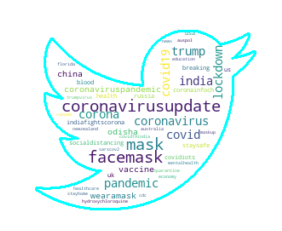

In [11]:
# WordCloud with image
#import os
#to get the current working directory for open image
#directory = os.getcwd()
#print(directory)
stopwords = set(STOPWORDS)
mask = np.array(Image.open("/Users/chloehuang/Twitter.png"))
wordcloud = WordCloud(stopwords=stopwords, background_color="white",contour_color='aqua',contour_width=3, max_words=100, mask=mask).generate(' '.join(modified["Words"]))
# create twitter image
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
# store to file
plt.savefig("twitter2.png", format="png")
plt.show()

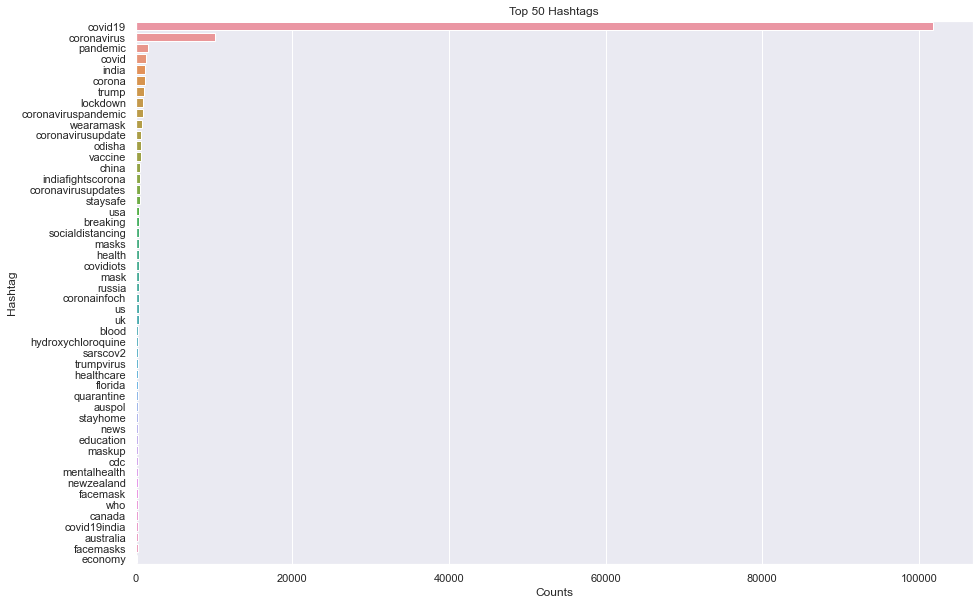

In [12]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(15,10))
sns.barplot(modified["Counts"],modified["Words"])
plt.title("Top 50 Hashtags")
plt.xlabel("Counts")
plt.ylabel("Hashtag")
plt.show()

(array([18468., 18472., 18475., 18479., 18483., 18487., 18491., 18495.,
        18499., 18503.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

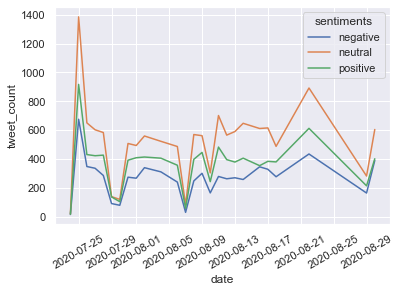

In [13]:
data_agg=data[['date','sentiments','text']]
data_agg['date'] =  pd.to_datetime(data_agg['date']).dt.date 
groups=data_agg.groupby(['date','sentiments'])
data_agg =groups.aggregate('count').reset_index()
data_agg=data_agg.rename(columns={'text': 'tweet_count'})

sns.lineplot(data=data_agg, x="date", y="tweet_count", hue="sentiments")
plt.xticks(rotation = 30)

([<matplotlib.patches.Wedge at 0x7fe789df8670>,
 [Text(0.7121726395525068, 0.8383377192234734, 'Negative'),
  Text(-1.0566873292628787, 0.3056335848287702, 'Netural'),
  Text(0.45119967458126176, -1.0032042930818048, 'Positive')],
 [Text(0.38845780339227637, 0.45727511957644, '28%'),
  Text(-0.576374906870661, 0.16670922808842006, '36%'),
  Text(0.24610891340796093, -0.5472023416809844, '37%')])

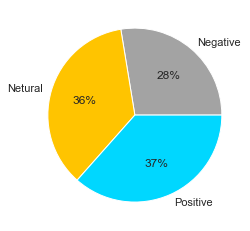

In [14]:
#data_agg.groupby('sentiments').sum() to get the count numbers
data_sum=[30945,40239,40999]
data_label=['Negative', 'Netural', 'Positive']
colors = sns.color_palette('bright')[7:10]
plt.pie(data_sum,labels = data_label, colors = colors, autopct='%.0f%%')

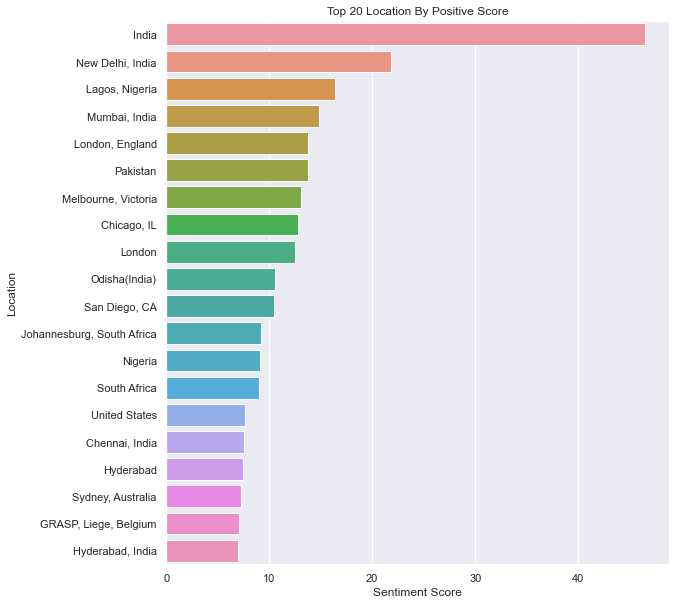

In [15]:
countries=pd.DataFrame(data =data, columns = ["sentiment_score","user_location"])
countries = countries.loc[countries["user_location"]!="WORLDWIDE"]
countries = countries.loc[countries["user_location"].notnull()]
countries = countries.sort_values(by = "sentiment_score",ascending=False)
countries = countries.groupby("user_location").sum().sort_values(by = "sentiment_score",ascending=False)[:20]

plt.figure(figsize=(9,10))
sns.barplot(list(countries.values.flatten()),countries.index,)
plt.title("Top 20 Location By Positive Score")
plt.xlabel("Sentiment Score")
plt.ylabel("Location")
plt.show()

In [16]:
## Numerical Summary 
dataa=pd.DataFrame(data[['date','sentiments']])

dataa['date'] = pd.to_datetime(dataa['date'], format='%Y-%m-%d %H:%M:%S',)
dataa['Day'] = [d.date() for d in dataa['date']]
dataa['Time'] = [d.time() for d in dataa['date']]

day_sentiments = dataa.groupby(['Day', 'sentiments']).agg({'Time': 'count'})
day_total = dataa.groupby(['Day']).agg({'Time': 'count'})

pd.set_option("display.max_rows", None, "display.max_columns", None)
day_sentiments.div(day_total, level='Day').round(3) * 100

Time
Day        sentiments      
2020-07-24 negative    29.2
           neutral     37.5
           positive    33.3
2020-07-25 negative    22.7
           neutral     46.5
           positive    30.8
2020-07-26 negative    24.3
           neutral     45.6
           positive    30.1
2020-07-27 negative    24.7
           neutral     44.3
           positive    31.1
2020-07-28 negative    22.0
           neutral     45.1
           positive    32.9
2020-07-29 negative    24.7
           neutral     37.9
           positive    37.4
2020-07-30 negative    26.0
           neutral     39.7
           positive    34.3
2020-07-31 negative    23.3
           neutral     43.3
           positive    33.4
2020-08-01 negative    22.8
           neutral     42.2
           positive    35.0
2020-08-02 negative    25.9
           neutral     42.6
           positive    31.5
2020-08-04 negative    25.1
           neutral     42.2
           positive    32.7
2020-08-06 negative    22.1
           neutral     45.0
           positive    32.9
2020-08-07 negative    17.5
           neutral     48.2
           positive    34.3
2020-08-08 negative    20.4
           neutral     46.9
           positive    32.7
2020-08-09 negative    23.0
           neutral     43.0
           positive    34.1
2020-08-10 negative    23.1
           neutral     42.7
           positive    34.1
2020-08-11 negative    19.0
           neutral     48.0
           positive    33.0
2020-08-12 negative    21.4
           neutral     46.2
           positive    32.3
2020-08-13 negative    21.7
           neutral     47.7
           positive    30.6
2020-08-14 negative    19.6
           neutral     49.4
           positive    30.9
2020-08-16 negative    26.4
           neutral     46.7
           positive    27.0
2020-08-17 negative    24.7
           neutral     46.4
           positive    28.9
2020-08-18 negative    24.2
           neutral     42.6
           positive    33.2
2020-08-22 negative    22.4
           neutral     46.0
           positive    31.6
2020-08-29 negative    24.8
           neutral     42.8
           positive    32.4
2020-08-30 negative    27.9
           neutral     43.3
           positive    28.8

Mean:  0.03802224656442907
0.35708522518921537


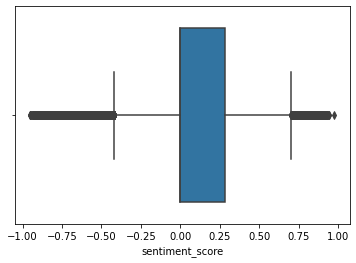

In [8]:
#use boxplot to check outlier
sns.boxplot(x=data['sentiment_score']) 
Q1 = data['sentiment_score'].quantile(0.25)
Q3 = data['sentiment_score'].quantile(0.75)
IQR = Q3 - Q1
Lower_Fence = Q1 - (1.5 * IQR)
print("Mean: ",data['sentiment_score'].mean())
print(data['sentiment_score'].std())

# all data are within four std from the mean, so dont need to remove any data

fit.slope: -5.984058342209634e-09
fit.intercept 9.593006940412367
fit.pvalue 0.05080276147430415
0.00021105886916216997


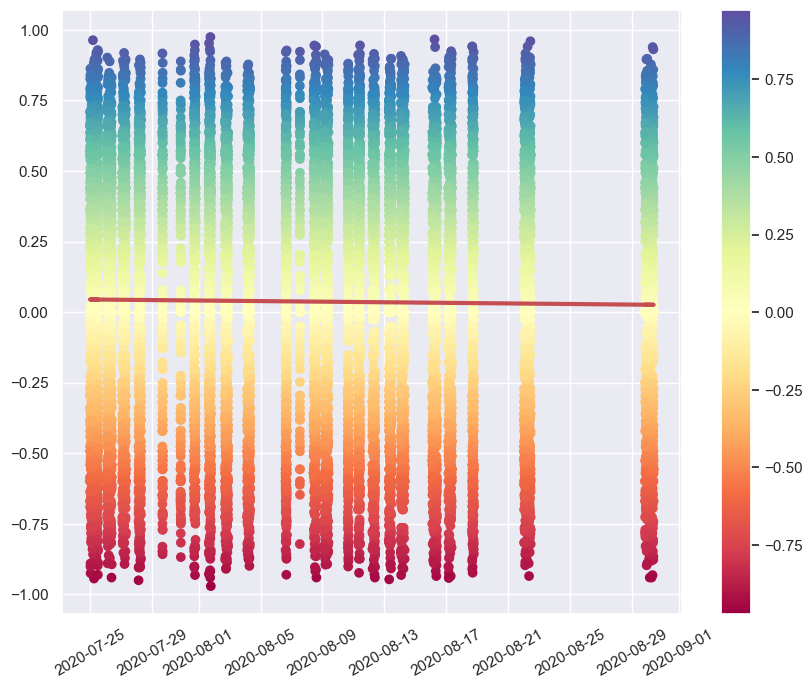

In [59]:
## Regression model

##Linear Regression 
data['date'] =  pd.to_datetime(data['date'], format='%Y-%m-%d %H:%M:%S')
def to_timestamp(t):
    return datetime.timestamp(t)
data['timestamp'] = data['date'].apply(to_timestamp)

X = data['timestamp']
y = data['sentiment_score']
X_train, X_valid, y_train, y_valid = train_test_split(X, y,test_size = 0.4, random_state = 42)

fit = stats.linregress(X_train ,y_train)


data['prediction'] = data['timestamp']*fit.slope + fit.intercept
print("fit.slope:",fit.slope)
#fit.slope<0, so the sentimen_score has a slight decrease during the period
print("fit.intercept",fit.intercept)
print("fit.pvalue", fit.pvalue) 
##since p value<0.05, reject H0, the ratings has been changing over time
plt.xticks(rotation = 30)
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
plt.scatter(data['date'] , data['sentiment_score'], c=data['sentiment_score'], cmap='Spectral')
plt.colorbar()
plt.plot(data['date'] , data['timestamp']*fit.slope + fit.intercept , 'r-' , linewidth =3)
plt.savefig("regression.png", format="png")
r_value = fit.rvalue
r_sq = r_value*r_value
print(r_sq)

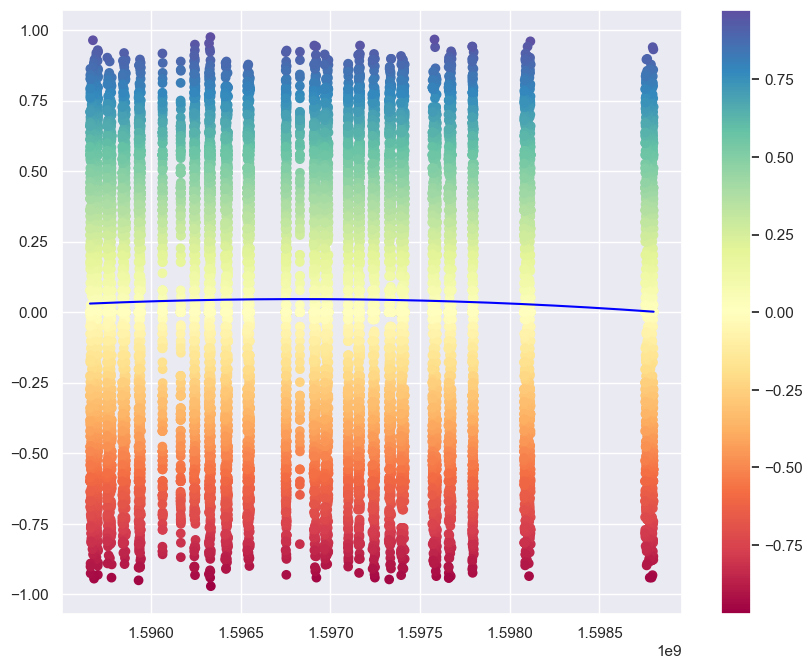

coefficient of determination: 0.0009006108020995773


,Model,R^2
1,Polynomial Regression,0.000901
0,Linear Regression,0.000211


In [61]:
from sklearn.preprocessing import PolynomialFeatures # importing a class for Polynomial Regression
from sklearn.linear_model import LinearRegression
X=data['timestamp']
X=X.values.reshape(-1, 1)
y=data['sentiment_score']
poly_reg = PolynomialFeatures(degree=3)
X_poly = poly_reg.fit_transform(X)
lin_reg2 = LinearRegression()
lin_reg2.fit(X_poly,y)
 
X_grid = np.arange(min(X),max(X),0.1)
X_grid = X_grid.reshape(len(X_grid),1) 
plt.scatter(data['timestamp'] , data['sentiment_score'], c=data['sentiment_score'], cmap='Spectral')
plt.colorbar()
plt.plot(X_grid, lin_reg2.predict(poly_reg.fit_transform(X_grid)),color='blue') 
plt.savefig("Polynomial.png", format="png")
plt.show()
model= lin_reg2.fit(X_poly,y)
r_sq1 = model.score(X_poly,y)
print('coefficient of determination:', r_sq1)

models = pd.DataFrame({
        'Model': ['Linear Regression', 'Polynomial Regression'],
        'R^2': [r_sq,r_sq1]})

models.sort_values(by='R^2', ascending=False)

(array([  433.,  1586.,  2148.,  1875., 13638.,  2106.,  2366.,  3743.,
         1734.,   497.]),
 array([-0.996397  , -0.80349064, -0.61058427, -0.41767791, -0.22477154,
        -0.03186517,  0.16104119,  0.35394756,  0.54685392,  0.73976029,
         0.93266665]),
 <BarContainer object of 10 artists>)

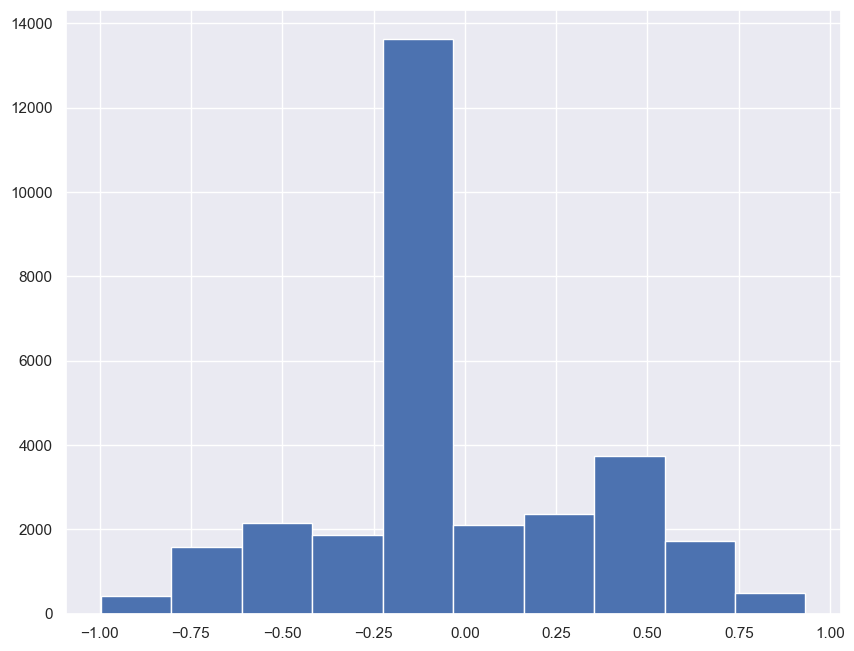

In [61]:
residuals=data['sentiment_score']-data['prediction']
plt.hist(residuals)#the requirement of normality can be softened with kind-of-normal data and n>=40